In [1]:
%cd "/data/ai_club/team_C/"

/data/ai_club/team_C


In [2]:
!pip install spectral --user

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
from sklearn import svm
import numpy as np
from sklearn.model_selection import train_test_split
import joblib
from spectral import *
from PIL import Image, ImageFile
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D 
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [11]:
#Model Setup
#Data Files
data_train = np.load('CNN/spectral_lymph_tile_array_3_9_22_left_update_1.npy')
non_data_train = np.load('CNN/spectral_non_tile_array_3_9_22_left_update_1.npy')
data_test = np.load('CNN/spectral_lymph_tile_array_3_9_22_right_update_1.npy')
non_data_test = np.load('CNN/spectral_non_tile_array_3_9_22_right_update_1.npy')

data_stack_train = np.vstack((data_train, non_data_train)) # One array of all training data
data_stack_test = np.vstack((data_test, non_data_test))   # One array of all test data
labels_train = np.append(np.ones(data_train.shape[0]), np.zeros(non_data_train.shape[0])) 
labels_test = np.append(np.ones(data_test.shape[0]), np.zeros(non_data_test.shape[0]))

X_train = data_stack_train[:, :]
y_train = labels_train[:]
X_test =  data_stack_test[:, :]
y_test = labels_test[:]
print("Data Loaded")
#Model
model=Sequential()
model.add(Conv2D(filters=128,kernel_size=3,padding="same",activation="relu",input_shape=(17,17,394)))
model.add(Conv2D(filters=16,kernel_size=3,padding="same",activation="relu"))
model.add(Flatten())
model.add(Dense(768,activation="relu"))
model.add(Dense(1,activation="sigmoid"))  
print(model.summary())
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy']) #compile Model
history=model.fit(X_train,y_train,epochs=15, validation_data=(X_test,y_test)) #train model

Data Loaded
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 17, 17, 128)       454016    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 16)        18448     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4624)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 768)               3552000   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 769       
Total params: 4,025,233
Trainable params: 4,025,233
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
595/595 [==============================] - 83s 140ms/step - loss: 0.4056 - accurac

(17912, 20292, 394)
(17912, 20292)


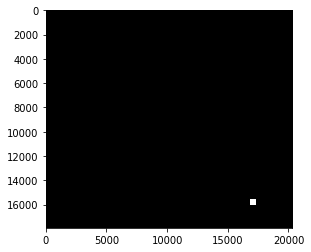

In [4]:
#Loading Spectral Array and creating cropped spectral array 
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True
spectral_img = open_image('ov-63-hd-16ca.hdr')
print(spectral_img.shape)

#### SET (X,Y) Coordinates and size of window here (so far I found size > ~500 to be unstable(uses more than memory allows for) )
#this code should be functionalized...

size=500 #Squaresize  
# the x and y coords are backwards
crop_x=14850+700
crop_y=16750
spectral_shape=spectral_img.shape
spectral_2d_shape=spectral_shape[:2]
print(spectral_2d_shape)
mask = np.zeros((spectral_2d_shape))
mask[crop_x:(crop_x+size),crop_y:(crop_y+size)]=1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(mask, aspect='equal', cmap=plt.cm.gray, interpolation='nearest')


In [ ]:
#Create 17x17 tiles
# Tile radius (1 = 3x3, 2 = 5x5, 3 = 7x7, etc.)
tr = 8

# Finding (y,x) tuple for where the mask is True
y, x = np.where(mask == True)

# Declaring pixel array
tw = 1 + (tr * 2)
test_spectral_result = np.empty((len(y), tw, tw, 394))

# # Append the pixels in the spectral image to the pixel array for every (y,x) and (ny,nx) tuple
print("Creating spectral array...")
for index, point in enumerate(zip(y, x)):
    px, py = point[1], point[0]
    #print((index/float(len(y)))*100) # If you want to see progress for large tables
    test_spectral_result[index] = spectral_img[py-tr:py+tr+1, px-tr:px+tr+1]
print("Done")

In [11]:
predictions=model.predict(test_spectral_result)

(250000, 1)
(500, 500)


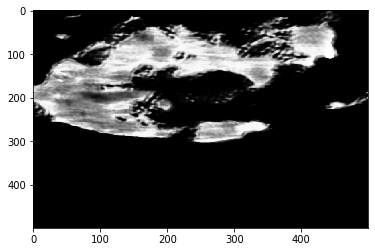

In [12]:
print(predictions.shape)
predictions=predictions.reshape(size,size)
print(predictions.shape)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(predictions, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')
#im = Image.fromarray(predictions)
#im_rgb = im.convert('RGB')
#im_rgb.save("predictions.png")
plt.imsave('test.png', predictions , cmap=plt.cm.gray)

(17912, 20292)


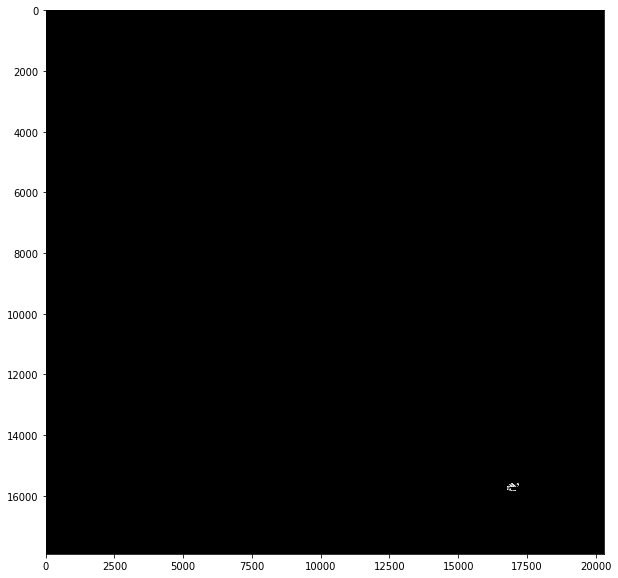

In [13]:
#Make a mask file out of this file for easy comparison to hyperspectral file
output_mask = np.zeros((17912, 20292))
output_mask[crop_x:(crop_x+size),crop_y:(crop_y+size)]=predictions
print(output_mask.shape)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
image_file=ax.imshow(output_mask, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')

In [14]:
# Save the image:
image_file = Image.fromarray(output_mask, mode="1")
filename="predictions_mask_x_" + str(crop_x) +"_y_" +str(crop_y) +"_size_" +str(size) 
print(filename)
#Set colormap https://kbkb-wx-python.blogspot.com/2015/12/python-transparent-colormap.html
colors = [(1,1,1,c) for c in np.linspace(0,1,100)]
cmapwhite = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)
plt.imsave(f"{filename}_white.png", output_mask , cmap=cmapwhite)#cmap=plt.cm.gray)

predictions_mask_x_15550_y_16750_size_500
